In [1]:
import yaml
import cv2
import torch
import matplotlib.pyplot as plt
from Datasets.create_dataset import get_dataset, SkinDataset2, StrongWeakAugment2
from Utils.pieces import DotDict
import numpy as np
from Models.Transformer.SwinUnet import SwinUnet
import os
import pandas as pd

config = yaml.load(open("Configs/multi_train_local.yml"), Loader=yaml.FullLoader)
config["fold"] = 1
config["data"]["supervised_ratio"] = 0.01
# update dataset
ls_update_keys = [
    "name",
    "save_folder",
    "test_folder",
    "train_folder",
    "val_folder",
]
for key in ls_update_keys:
    config["data"][key] = config["data"][key].replace("isic2018", "lisc")

config = DotDict(config)
dataset = get_dataset(
    config,
    img_size=config["data"]["img_size"],
    supervised_ratio=config["data"]["supervised_ratio"],
    train_aug=config["data"]["train_aug"],
    k=config["fold"],
    lb_dataset=SkinDataset2,
    ulb_dataset=StrongWeakAugment2,
)

test_loader = torch.utils.data.DataLoader(
    dataset["val_dataset"],
    batch_size=1,
    shuffle=False,
    num_workers=config.test.num_workers,
    pin_memory=True,
    drop_last=False,
)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


Train Data: A172_Phase_A7_1_00d00h00m_3.npy - 1296
Labeled Data: A172_Phase_A7_2_00d08h00m_1.npy - 12
Unlabeled Data: A172_Phase_A7_1_00d00h00m_3.npy - 1284
Val Data: A172_Phase_A7_1_00d12h00m_1.npy - 324


# LiveCells (8 categories)

In [4]:
import torch.nn as nn
from Utils.losses import dice_loss


# Assuming your model is a custom ConvNet
def load_model(model_path):
    model = model = SwinUnet(img_size=224)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


dataset_name = "livecells"
criterion = [nn.BCELoss(), dice_loss]

ls_algo_name = ["fixmatch", "cct", "ccvc", "cps", "unimatch"]
ls_algo_name = ["fixmatch", "ccvc", "cps"]
ls_algo_model = {}
for algo_name in ls_algo_name:
    model_path = os.path.join(
        os.getcwd(), "outputs", dataset_name, algo_name, "best.pth"
    )
    model = load_model(model_path)
    model = model.cuda()
    ls_algo_model[algo_name] = model

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


/tmp/ipykernel_665728/561583711.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---
SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


In [17]:
# cnt = 1
# n_loop = 2
best_inferences = []
for idx, batch in enumerate(test_loader):
    # if cnt > n_loop:
    #     break

    # cnt += 1
    file_id = batch["name"][0]
    cell_type = file_id.split("_")[0]
    org_img = batch["org_image"].cuda().float()
    img = batch["image"].cuda().float()
    label = batch["label"].cuda().float()

    org_img_output = org_img[0].cpu().numpy().transpose(1, 2, 0).astype(int)
    label_output = label[0].cpu().numpy().transpose(1, 2, 0).astype(int)
    algo_outputs = [file_id, cell_type, org_img_output, label_output]

    mean_loss = []
    for algo in ls_algo_name:
        model = ls_algo_model[algo]

        with torch.no_grad():
            pred_output = model(img)
            pred_output = torch.sigmoid(pred_output)

            # calculate loss
            assert pred_output.shape == label.shape
            losses = []
            for function in criterion:
                losses.append(function(pred_output, label))

            # for visualization
            pred_output = pred_output[0].cpu().numpy().transpose(1, 2, 0)
            mean_loss.append(losses[0].cpu().numpy())
            algo_outputs.append(pred_output)

    best_inferences.append(tuple(algo_outputs + [np.array(mean_loss).mean()]))

In [18]:
len(best_inferences)

324

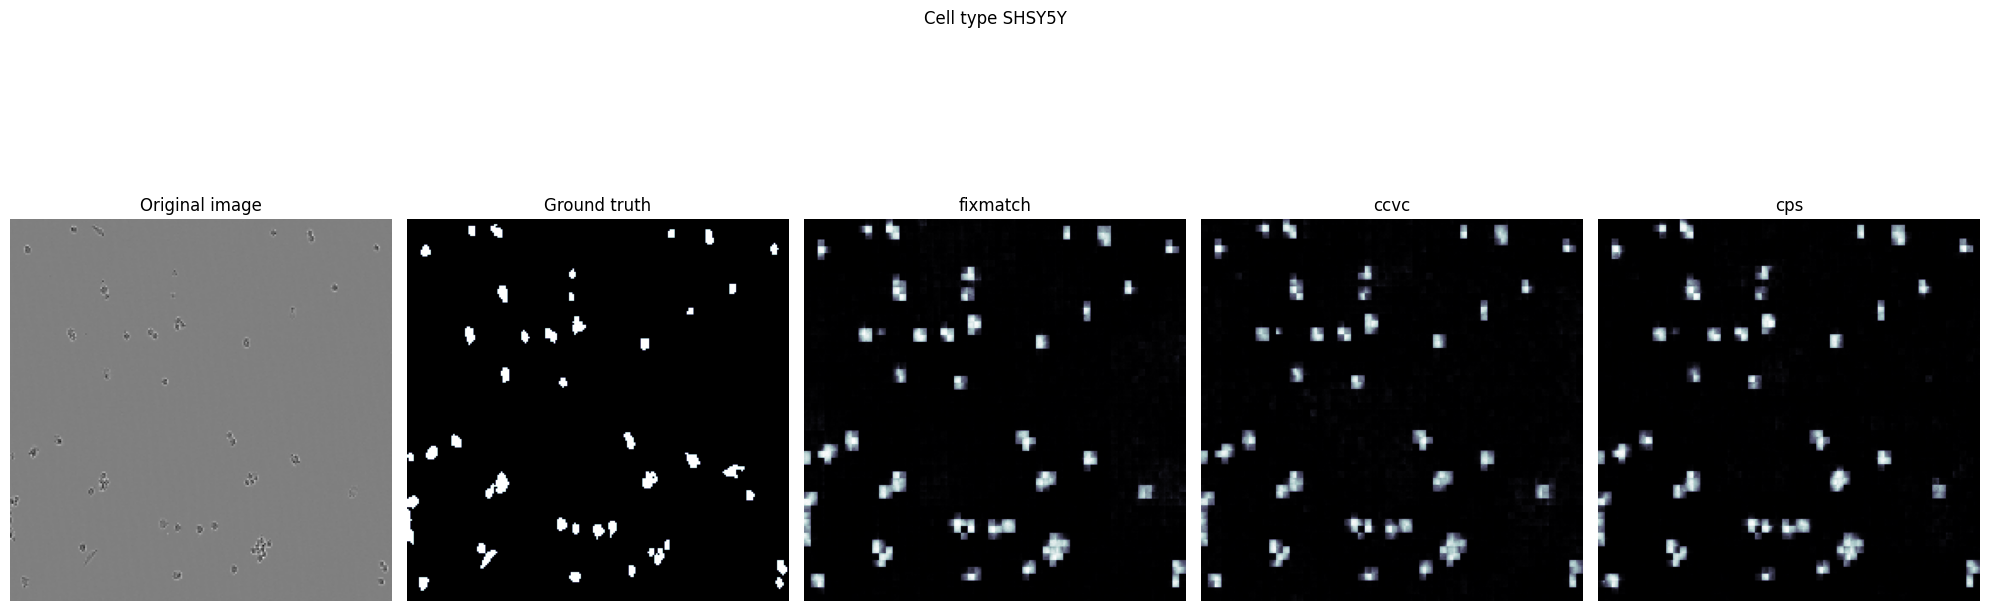

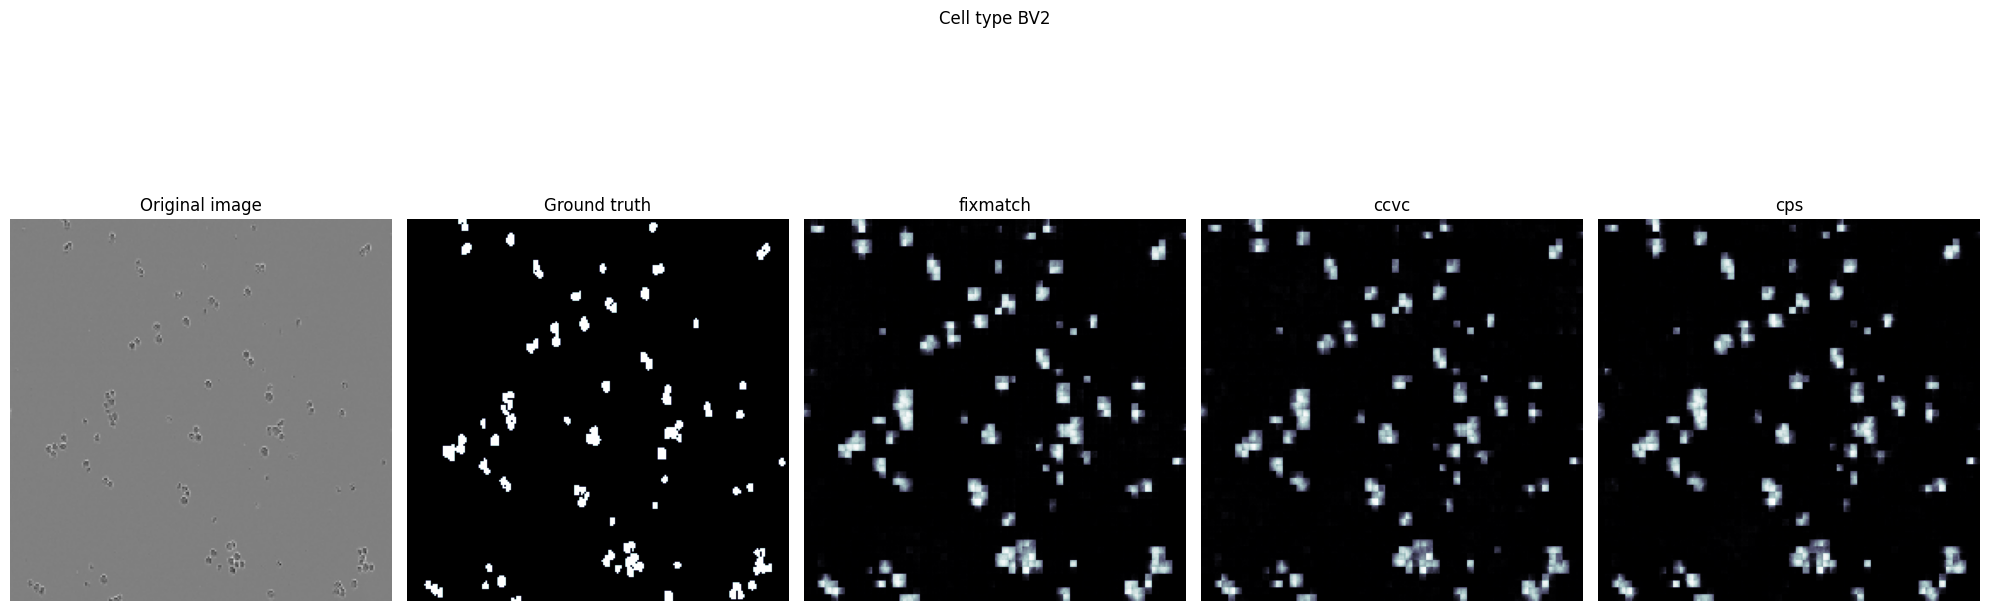

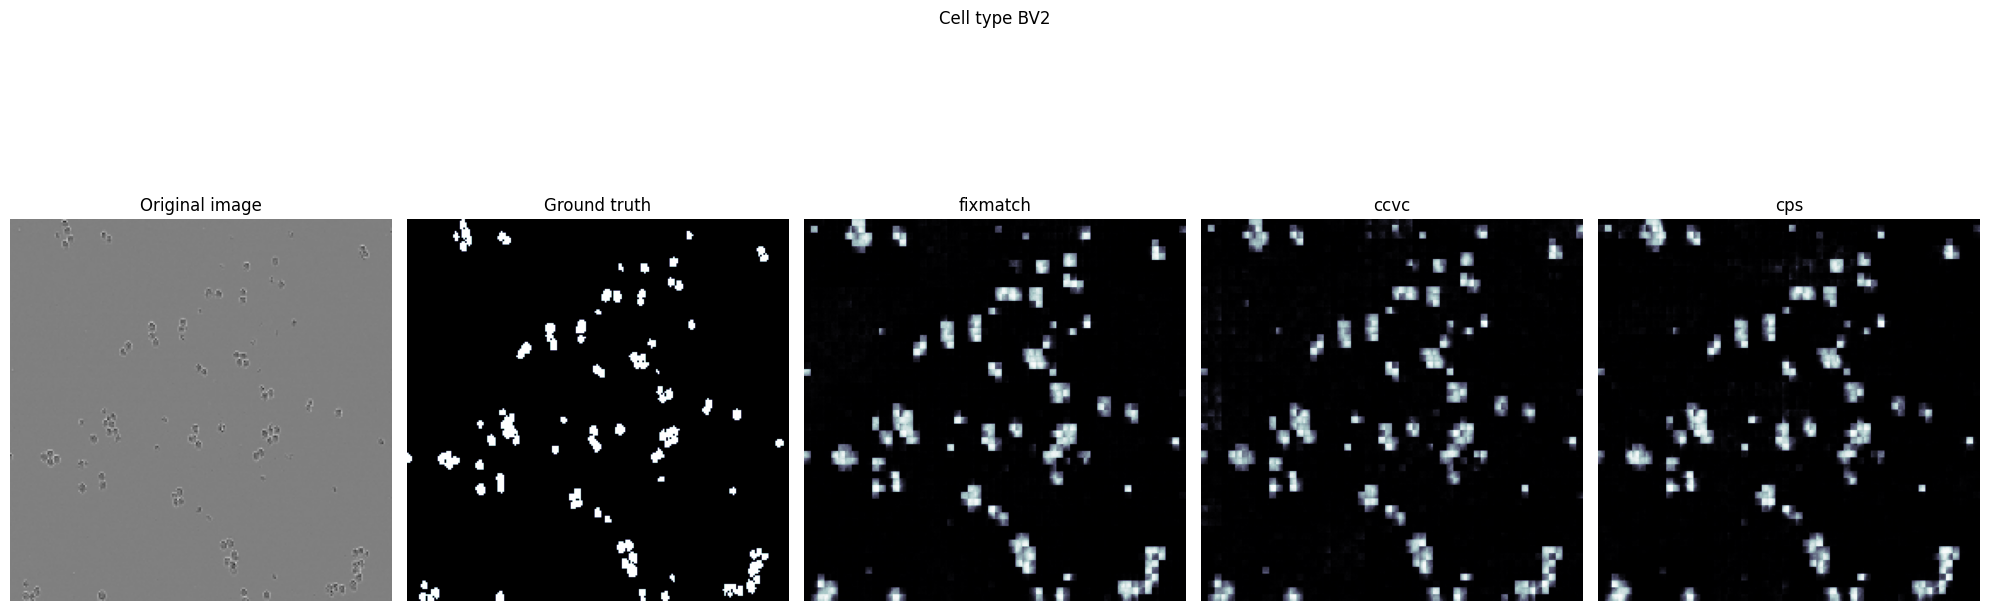

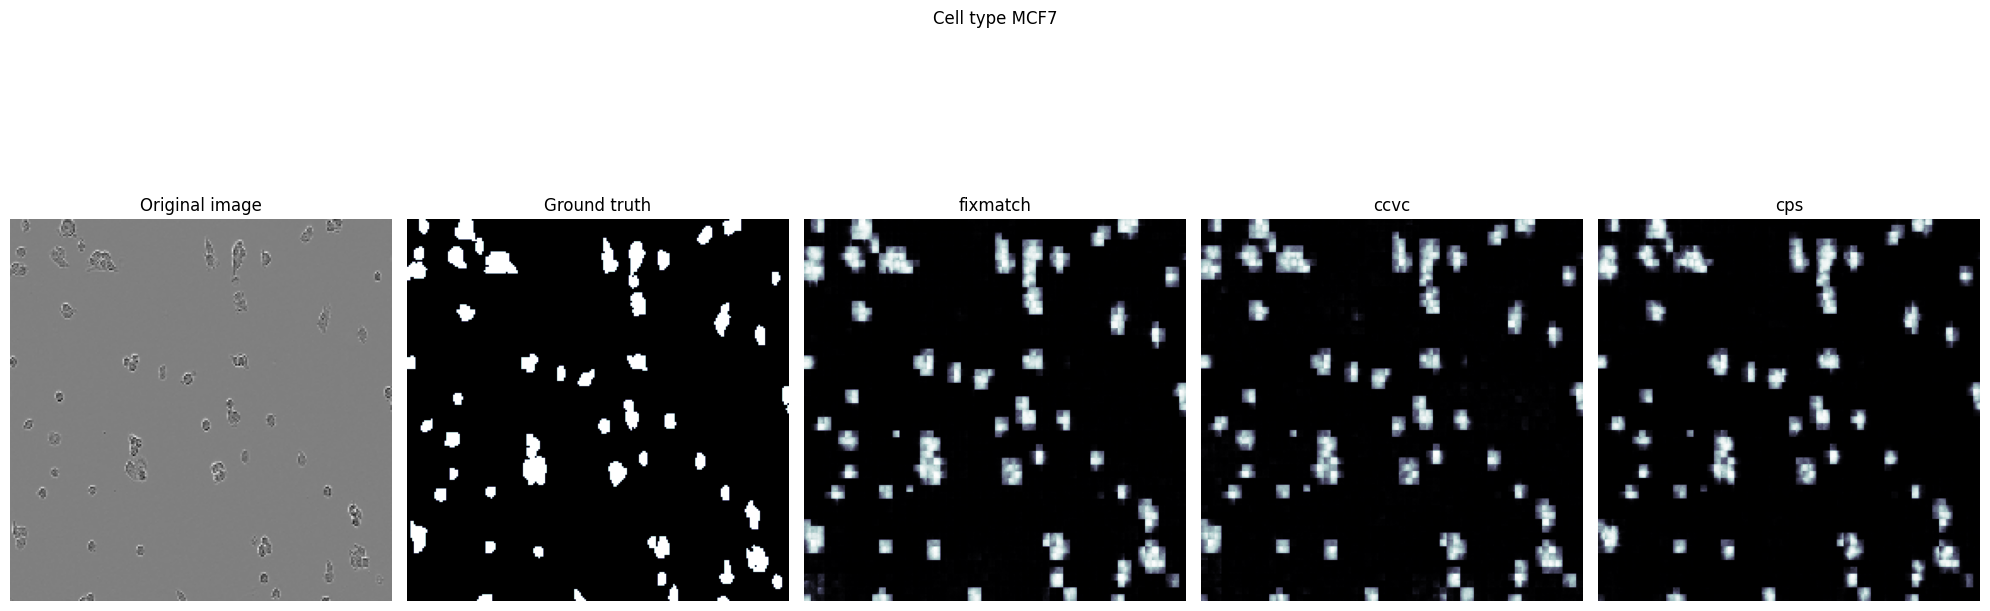

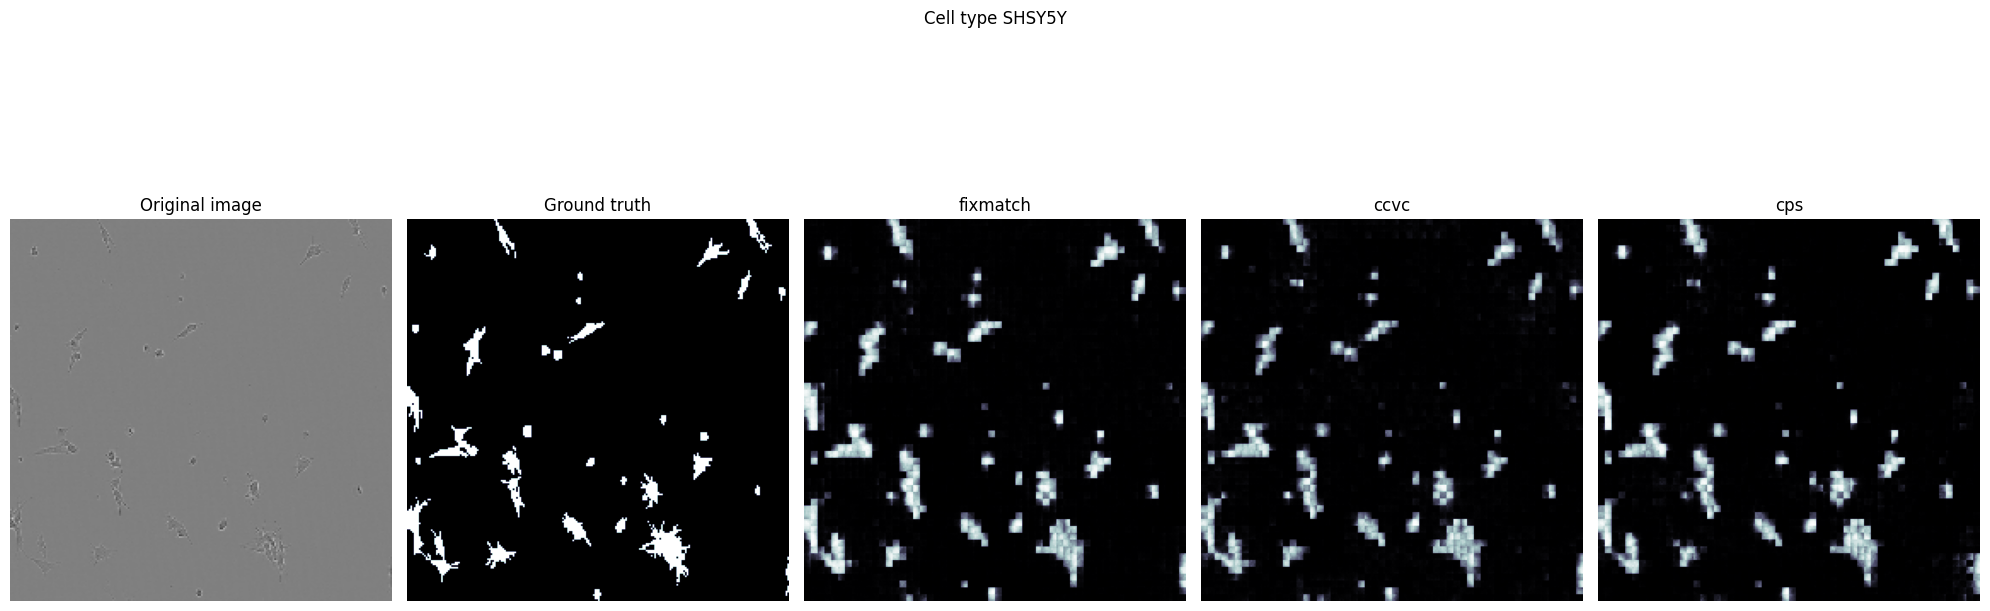

In [21]:
# Sort by loss in descending order
num_images = 10
best_inferences.sort(key=lambda x: x[-1], reverse=False)
type_check_num = {}
for i, inf_results in enumerate(best_inferences[:num_images]):
    file_id, cell_type, org_img, label = inf_results[:4]
    ls_algo_preds = inf_results[4:]

    if cell_type not in type_check_num:
        type_check_num[cell_type] = 0
    if type_check_num[cell_type] > 1:
        continue

    type_check_num[cell_type] += 1

    # plot original
    fig, axes = plt.subplots(1, 1 + len(ls_algo_preds), figsize=(20, 8))

    axes[0].imshow(org_img, cmap="bone")
    axes[0].set_title("Original image")
    axes[0].axis("off")

    axes[1].imshow(label, cmap="bone")
    axes[1].set_title("Ground truth")
    axes[1].axis("off")

    for i, algo_name in enumerate(ls_algo_name):
        axes[i + 2].imshow(ls_algo_preds[i], cmap="bone")
        axes[i + 2].set_title(algo_name)
        axes[i + 2].axis("off")

    class_label = "Cell type " + cell_type
    fig.suptitle(class_label)

    plt.tight_layout()
    plt.show()

In [2]:
# plot origin + mask GT

In [ ]:
# plot origin + predicted mask (fixmatch, cct, cps, ccvc, unimatch)